# Implementation of SoccerCPD

In [1]:
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
%matplotlib inline


## Toy Dataset

In [2]:
# Pitch normalized to [-50,50] x [-30,30]

F442 = np.array([
    (-40,  20), (-40,   7), (-40,  -7), (-40, -20),   # Defenders (4)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,   8), ( 25,  -8)                            # Forwards (2)
])
F343 = np.array([
    (-40,  10), (-40,   0), (-40, -10),               # Defenders (3)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,  18), ( 25,   0), ( 25, -18)                # Forwards (3)
])


In [3]:
def simulate_roles(F1, F2, T=400, cp=200, sigma=2.0):
    """
    Simulates role trajectories with a single formation change.
    """
    N = len(F1)
    V = np.zeros((T, N, 2))

    for t in range(T):
        mu = F1 if t < cp else F2
        V[t] = mu + sigma * np.random.randn(N,2)

    return V


V = simulate_roles(F442, F343)


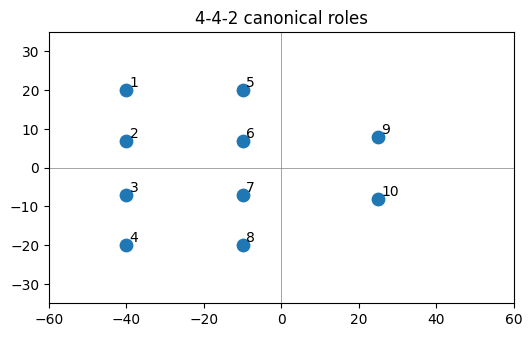

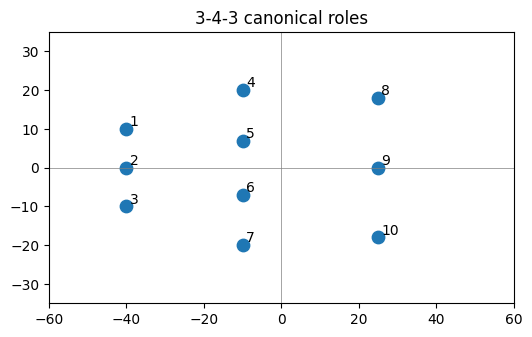

In [4]:
def plot_formation(points, title=""):
    x, y = points[:,0], points[:,1]

    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=80)

    for i, (xi, yi) in enumerate(zip(x,y)):
        plt.text(xi+0.8, yi+0.8, str(i+1))

    plt.axhline(0,color='gray',linewidth=0.5)
    plt.axvline(0,color='gray',linewidth=0.5)

    plt.title(title)
    plt.xlim(-60,60)
    plt.ylim(-35,35)

    plt.gca().set_aspect('equal', 'box')
    plt.show()


plot_formation(F442, "4-4-2 canonical roles")
plot_formation(F343, "3-4-3 canonical roles")


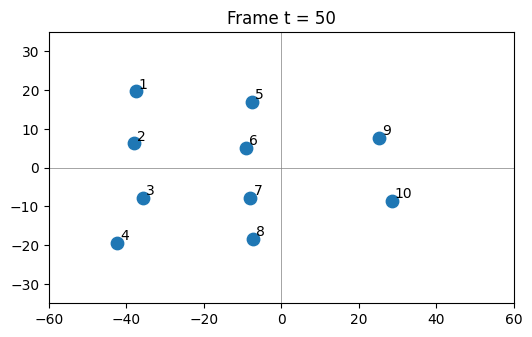

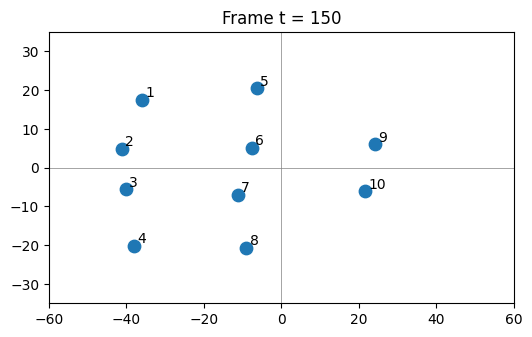

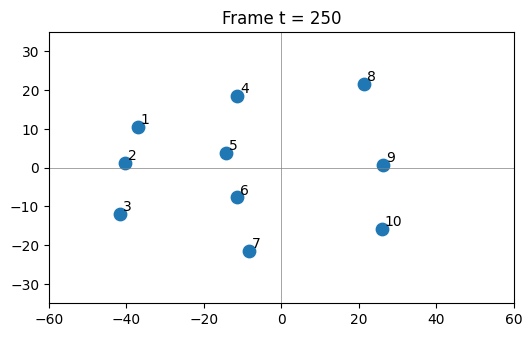

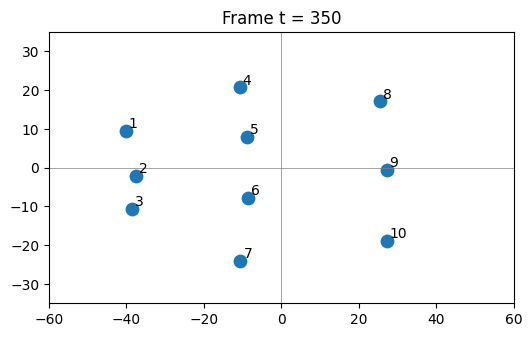

In [5]:

def plot_frame(V, t):
    plot_formation(V[t], f"Frame t = {t}")


plot_frame(V, 50)    # before change
plot_frame(V, 150)
plot_frame(V, 250)  # after change
plot_frame(V, 350)


## Sectino 4.1 Delaunay Triangulation

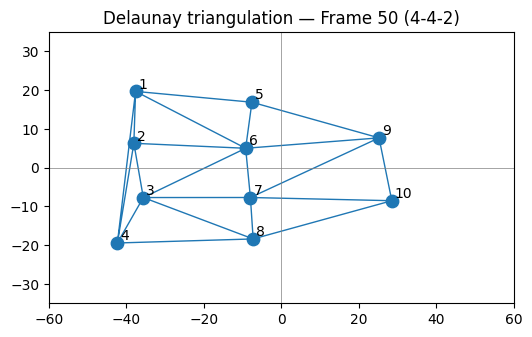

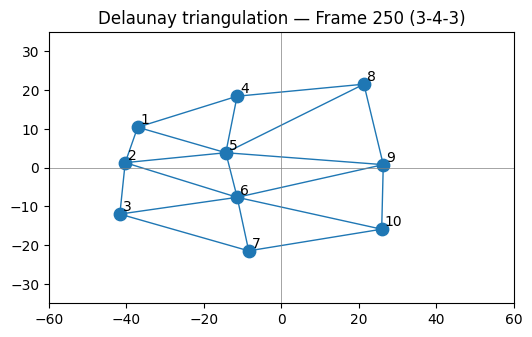

In [6]:
def plot_delaunay(V_frame, title):
    tri = Delaunay(V_frame)

    plt.figure(figsize=(6,4))
    plt.triplot(V_frame[:,0], V_frame[:,1], tri.simplices, lw=1)
    plt.scatter(V_frame[:,0], V_frame[:,1], s=80)

    for i, (x,y) in enumerate(V_frame):
        plt.text(x+0.8, y+0.8, str(i+1))

    plt.title(title)
    plt.axhline(0,color='gray',lw=0.5)
    plt.axvline(0,color='gray',lw=0.5)
    plt.xlim(-60,60)
    plt.ylim(-35,35)
    plt.gca().set_aspect('equal')
    plt.show()


plot_delaunay(V[50],  "Delaunay triangulation — Frame 50 (4-4-2)")
plot_delaunay(V[250], "Delaunay triangulation — Frame 250 (3-4-3)")


In [7]:
def delaunay_adjacency(V_frame: np.ndarray) -> np.ndarray:
    N = V_frame.shape[0]
    tri = Delaunay(V_frame)

    A = np.zeros((N, N), dtype=int)
    for simplex in tri.simplices:
        # simplex has 3 vertices -> 3 undirected edges
        for i in range(3):
            for j in range(i + 1, 3):
                a, b = simplex[i], simplex[j]
                A[a, b] = 1
                A[b, a] = 1
    return A

In [8]:
A = np.array([delaunay_adjacency(V[t]) for t in range(len(V))])

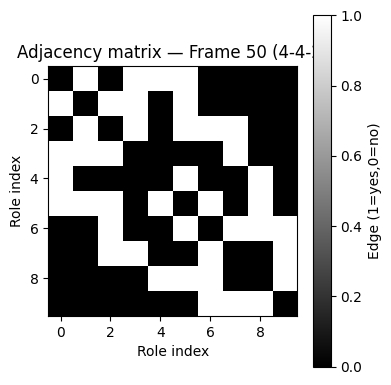

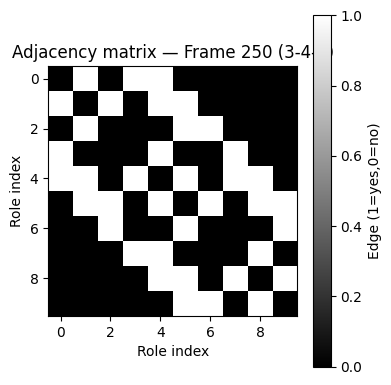

In [9]:
def plot_adjacency(A, title=""):
    plt.figure(figsize=(4,4))
    plt.imshow(A, cmap="gray")
    plt.colorbar(label="Edge (1=yes,0=no)")
    plt.xlabel("Role index")
    plt.ylabel("Role index")
    plt.title(title)
    plt.tight_layout()

plot_adjacency(A[50],  "Adjacency matrix — Frame 50 (4-4-2)")
plot_adjacency(A[250], "Adjacency matrix — Frame 250 (3-4-3)")


No handles with labels found to put in legend.


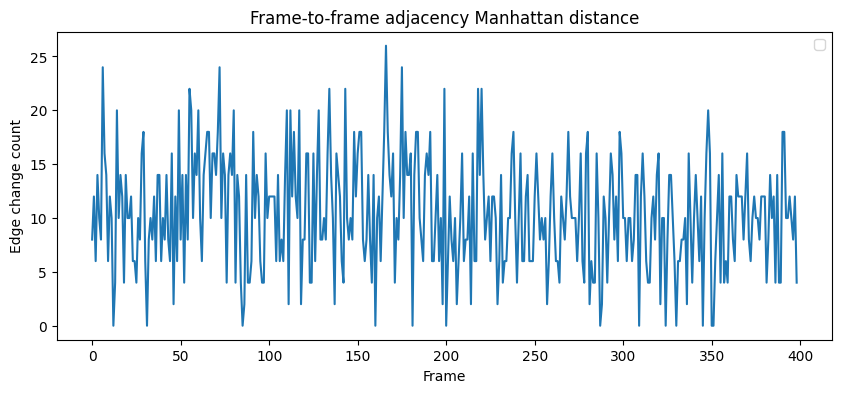

In [10]:
def manhattan(A1, A2):
    return np.sum(np.abs(A1 - A2))

deltas = np.array([manhattan(A[t], A[t+1]) for t in range(len(A)-1)])

plt.figure(figsize=(10,4))
plt.plot(deltas)
plt.title("Frame-to-frame adjacency Manhattan distance")
plt.xlabel("Frame")
plt.ylabel("Edge change count")
plt.legend()
plt.show()


In [11]:
def manhattan_adj(A1: np.ndarray, A2: np.ndarray) -> float:
    return np.abs(A1 - A2).sum()


In [12]:
V = simulate_roles(F442, F343, T=400, cp=200, sigma=2.0)
T, N, _ = V.shape
A_seq = np.array([delaunay_adjacency(V[t]) for t in range(T)])  # shape (T, N, N)


In [13]:
def pairwise_manhattan(A_seq: np.ndarray) -> np.ndarray:
    """
    A_seq: (T, N, N)
    returns D: (T, T) with D[i, j] = d_M(A_i, A_j)
    """
    T = A_seq.shape[0]
    D = np.zeros((T, T), dtype=float)
    for i in range(T):
        for j in range(i + 1, T):
            d = manhattan_adj(A_seq[i], A_seq[j])
            D[i, j] = d
            D[j, i] = d
    return D

D = pairwise_manhattan(A_seq)


In [14]:
A_mean_before = A_seq[:200].mean(axis=0)
A_mean_after  = A_seq[200:].mean(axis=0)
print("Manhattan distance between mean formations:",
      manhattan_adj(A_mean_before, A_mean_after))


Manhattan distance between mean formations: 20.680000000000003


In [15]:
import ruptures as rpt
# A_seq: (T, N, N)
X = A_seq.reshape(len(A_seq), -1)

# Ruptures baseline - changes in mean
model = rpt.Pelt(model="l2").fit(X)
cp_ruptures = model.predict(pen=10)

print("Ruptures CPs:", cp_ruptures)

Ruptures CPs: [70, 90, 95, 200, 400]


(<Figure size 1000x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

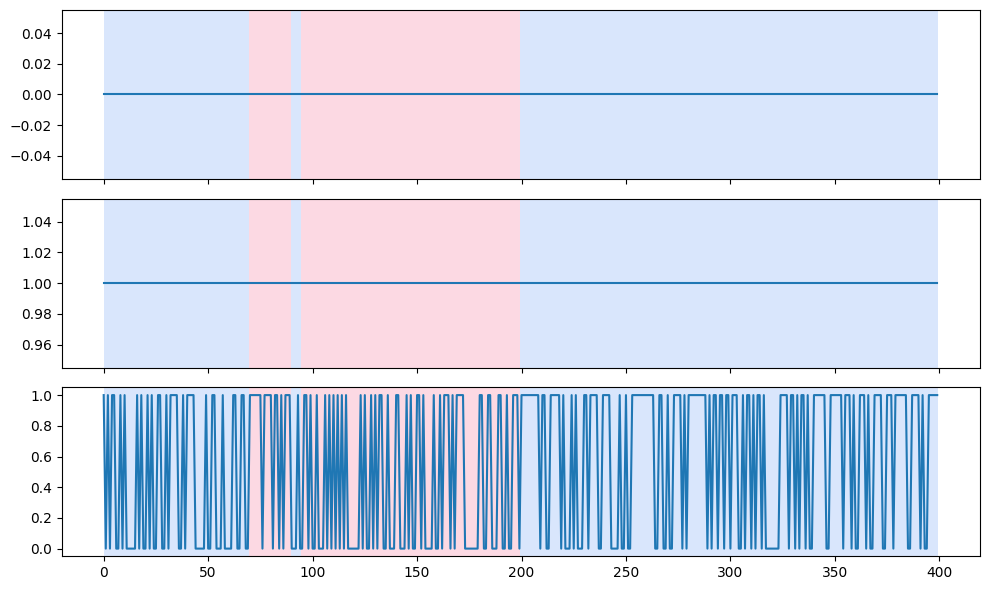

In [16]:
rpt.display(X[:, :3], cp_ruptures)


In [17]:
from sklearn.metrics import pairwise_distances

# flatten matrices
X = A_seq.reshape(len(A_seq), -1)

# Manhattan distance
D = pairwise_distances(X, metric="manhattan")


In [26]:
ro.r("exists('gSeg')")


0


In [29]:
print(ro.r("getNamespaceExports('gSeg')"))


[1] "gseg1_discrete" "nnl"            "gseg2_discrete" "gseg1"         
[5] "gseg2"         



Manhattan distance between mean formations: 20.879999999999995
Ruptures CPs: [90, 100, 115, 125, 200, 400]


R[write to console]: Error in vector("list", n) : invalid 'length' argument



RRuntimeError: Error in vector("list", n) : invalid 'length' argument


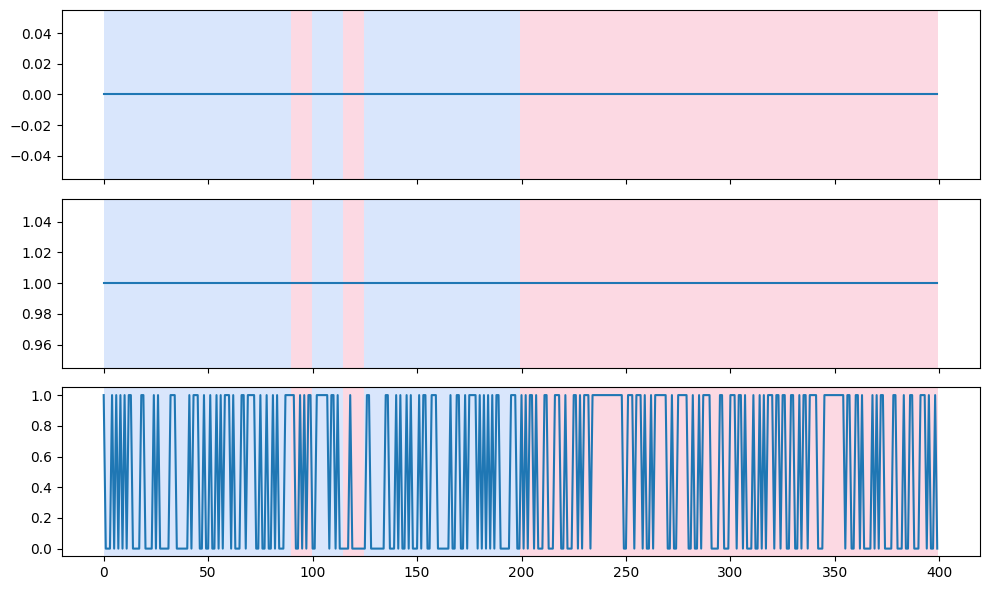

In [31]:
# =========================
# Imports
# =========================
import numpy as np
from scipy.spatial import Delaunay
from sklearn.metrics import pairwise_distances
import ruptures as rpt

import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

numpy2ri.activate()

# =========================
# Formations
# =========================
# Pitch normalized to [-50,50] x [-30,30]

F442 = np.array([
    (-40,  20), (-40,   7), (-40,  -7), (-40, -20),   # Defenders (4)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,   8), ( 25,  -8)                            # Forwards (2)
])

F343 = np.array([
    (-40,  10), (-40,   0), (-40, -10),               # Defenders (3)
    (-10,  20), (-10,   7), (-10,  -7), (-10, -20),   # Midfield (4)
    ( 25,  18), ( 25,   0), ( 25, -18)                # Forwards (3)
])

# =========================
# Simulation
# =========================
def simulate_roles(F1, F2, T=400, cp=200, sigma=2.0):
    """
    Simulate role trajectories with a single formation change.
    """
    N = len(F1)
    V = np.zeros((T, N, 2))
    for t in range(T):
        mu = F1 if t < cp else F2
        V[t] = mu + sigma * np.random.randn(N, 2)
    return V

T = 400
CP_TRUE = 200
SIGMA = 2.0

V = simulate_roles(F442, F343, T=T, cp=CP_TRUE, sigma=SIGMA)

# =========================
# Delaunay adjacency
# =========================
def delaunay_adjacency(V_frame):
    N = V_frame.shape[0]
    tri = Delaunay(V_frame)
    A = np.zeros((N, N), dtype=int)
    
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i+1, 3):
                a, b = simplex[i], simplex[j]
                A[a, b] = 1
                A[b, a] = 1
                
    return A

# Build sequence of adjacency matrices
A_seq = np.array([delaunay_adjacency(V[t]) for t in range(T)])

# =========================
# Distance matrix
# =========================
# Flatten adjacencies
X = A_seq.reshape(T, -1)

# Manhattan distance
D = pairwise_distances(X, metric="manhattan")

# =========================
# Sanity check
# =========================
# Distance between mean formations
A_mean_before = A_seq[:CP_TRUE].mean(axis=0)
A_mean_after  = A_seq[CP_TRUE:].mean(axis=0)
mean_dist = np.abs(A_mean_before - A_mean_after).sum()
print("Manhattan distance between mean formations:", mean_dist)

# =========================
# Baseline CPD – ruptures
# =========================
model = rpt.Pelt(model="l2").fit(X)
cp_ruptures = model.predict(pen=10)

print("Ruptures CPs:", cp_ruptures)

# Optional: plot ruptures result
rpt.display(X[:, :3], cp_ruptures)

# =========================
# g-segmentation via R
# =========================
# Push distance matrix to R
ro.globalenv["D"] = D

# Run discrete g-segmentation (average statistic)
ro.r("""
dist_obj <- as.dist(D)

res <- gSeg::gseg1(dist_obj)

cps <- res$cp
""")

cps_gseg = np.array(ro.globalenv["cps"], dtype=int)
print("gSeg CPs:", cps_gseg)

# Retrieve CPs
cps_gseg = np.array(ro.globalenv["cps"], dtype=int)

print("gSeg CPs:", cps_gseg)

# =========================
# Compare
# =========================
print("\n==== Final comparison ====")
print("True CP:", CP_TRUE)
print("Ruptures:", cp_ruptures)
print("gSeg:", cps_gseg)


In [34]:
ro.globalenv["D"] = D

ro.r("""
library(gSeg)

# ensure matrix type
D <- as.matrix(D)

n <- nrow(D)

# build nearest-neighbor graph (k=1)
edge_mat <- nnl(D, 1)

# IDs: all frames unique in synthetic data
ids <- 1:n

output <- gseg1_discrete(
    n,
    edge_mat,
    ids,
    statistics = "generalized",
    n0 = floor(0.1*n),
    n1 = floor(0.9*n)
)

chg_idx <- output$scanZ$generalized$tauhat_1
pval <- output$pval.appr$generalized_1
""")


R[write to console]: Error in `[<-`(`*tmp*`, e, 1, value = i) : subscript out of bounds



RRuntimeError: Error in `[<-`(`*tmp*`, e, 1, value = i) : subscript out of bounds
